In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import re
from datetime import datetime, timezone

In [6]:
df = pd.read_csv("omnipot.csv")
print(df.shape)
df.head()

(965090, 21)


,src_port,dst_port,timestamp,src_as,src_city,src_country,src_countryCode,src_geo_str,src_ip,src_proxy,...,dst_as,dst_city,dst_country,dst_countryCode,dst_geo_str,dst_ip,dst_proxy,dst_regionName,protocol,payload_4kb_hex
0,64787,445,1738746119923,AS8452 TE-AS,Alexandria,Egypt,EG,29.7432|30.9977,102.43.79.235,False,...,"AS20473 The Constant Company, LLC",Singapore,Singapore,SG,103.695|1.32123,45.32.124.12,False,South West,smb,000000efbfbdefbfbd534d4272000000001853efbfbd00...
1,59105,23,1740787252674,AS4788 TM TECHNOLOGY SERVICES SDN. BHD.,Puchong Batu Dua Belas,Malaysia,MY,101.6189|3.0662,175.143.203.217,False,...,"AS20473 The Constant Company, LLC",Seoul,South Korea,KR,126.978|37.5658,158.247.195.242,False,Seoul,telnet,NaN
2,13652,22,1743924731683,AS6939 Hurricane Electric LLC,Alameda,United States,US,-122.262|37.7688,184.105.247.252,False,...,"AS20473 The Constant Company, LLC",Querétaro City,Mexico,MX,-100.2899|20.5737,216.238.89.44,True,Querétaro,ssh,474554202f20485454502f312e310d0a486f73743a2032...
3,64010,445,1738746116417,AS8452 TE-AS,Alexandria,Egypt,EG,29.7432|30.9977,102.43.79.235,False,...,"AS20473 The Constant Company, LLC",Singapore,Singapore,SG,103.695|1.32123,45.32.124.12,False,South West,smb,00000054efbfbd534d4272000000001801280000000000...
4,59105,23,1740787252674,AS4788 TM TECHNOLOGY SERVICES SDN. BHD.,Puchong Batu Dua Belas,Malaysia,MY,101.6189|3.0662,175.143.203.217,False,...,"AS20473 The Constant Company, LLC",Seoul,South Korea,KR,126.978|37.5658,158.247.195.242,False,Seoul,telnet,NaN


This dataset has over 900k observations, and many columns.

In [7]:
pd.concat([df.isna().sum().rename("missing values"), df.dtypes.rename("datatype"), df.nunique().rename("unique values")], axis=1)

,missing values,datatype,unique values
src_port,0,int64,61590
dst_port,0,int64,33
timestamp,0,int64,675827
src_as,3149,object,6533
src_city,5,object,8869
src_country,0,object,199
src_countryCode,49,object,194
src_geo_str,0,object,15357
src_ip,0,object,112623
src_proxy,0,bool,2


There are several missing values, and most of the columns are objects which must be converted to numbers.

In [8]:
df["dst_as"].unique()[-1]

'AS20473 The Constant Company, LLC'

All the attacks were directed at The Constant Company LLC, likely the company that gave us the data.

### Missing Values

#### Country code

In [9]:
df.loc[df["src_countryCode"].isna(), "src_country"].unique()

array(['Namibia'], dtype=object)

In [10]:
all_codes = (df["src_countryCode"].unique().tolist() + df["dst_countryCode"].unique().tolist())
all_codes[:10]

['EG', 'MY', 'US', 'NL', 'SG', 'ID', 'PK', 'KH', 'RU', 'CN']

Every country code with NaN values is related to Namibia, since NA is not in the code list, we simply add it.

In [11]:
"NA" in all_codes

False

In [12]:
df.fillna({"src_countryCode":"NA"}, inplace=True)

#### Cities

In [13]:
df.loc[df["src_city"].isna(), "src_country"]

163708    Georgia
163711    Georgia
163720    Georgia
252881    Georgia
389318    Georgia
Name: src_country, dtype: object

In [14]:
df.loc[df["src_country"] == "Georgia", "src_city"].value_counts()

src_city
Tbilisi         432
Batumi           77
Kutaisi          15
Kvemo Teleti      9
Leselidze         2
Rustavi           1
Name: count, dtype: int64

Every missing source city is in Georgia. Since there is more than a single city in the observations, we don't guess, but add a new category instead.

In [15]:
df.fillna({"src_city":"other"}, inplace=True)

#### Autonomous System Number

In [16]:
df.loc[df["src_as"].isna(), ["src_country"]].value_counts().head(10)

src_country    
Seychelles         742
United States      505
South Africa       471
Ghana              418
France             261
Russia             197
Hong Kong          134
Nigeria             84
India               71
The Netherlands     56
Name: count, dtype: int64

In [17]:
df.fillna({"src_as" : "unk"}, inplace=True)

We really don't have way to know what how to replace the values. We add an "unknown" category.

#### Regions

In [18]:
df.loc[df["src_regionName"].isna(), "src_country"].value_counts()

src_country
Macao         122
Aruba          34
Antarctica     10
Curacao         5
Georgia         5
Norway          4
Name: count, dtype: int64

In [19]:
# df.loc[df["src_country"] == "Macao", "src_regionName"].value_counts()
# df.loc[df["src_country"] == "Aruba", "src_regionName"].value_counts()
# df.loc[df["src_country"] == "Antarctica", "src_regionName"].value_counts()
# df.loc[df["src_country"] == "Curacao", "src_regionName"].value_counts()
# df.loc[df["src_country"] == "Georgia", "src_regionName"].value_counts()
# df.loc[df["src_country"] == "Norway", "src_regionName"].value_counts()

In [20]:
df.loc[df["src_country"].isin(["Antarctica", "Aruba"]), "src_regionName"] = df.loc[df["src_country"].isin(["Antarctica", "Aruba"]), "src_regionName"].fillna("unk")
df.loc[df["src_country"] == "Curacao", "src_regionName"] = df.loc[df["src_country"] == "Curacao", "src_regionName"].fillna("Curaçao")
df.loc[df["src_country"].isin(["Norway", "Georgia", "Macao"]), "src_regionName"] = df.loc[df["src_country"].isin(["Norway", "Georgia", "Macao"]), "src_regionName"].fillna("other")


Based on the country and its area we can compute the missing values. Curacao had a single area (add it), Antarctica and Aruba had none(add "unk"), and the remaining had many (add "other").

In [21]:
df.isna().sum()[df.isna().sum() != 0] / len(df)

payload_4kb_hex    0.294
dtype: float64

Now only the payload has missing values and it's a large part of the data, 30%.

### Encodings

Next we try to extract features and encode categorical/string columns into numbers. For each of them we will remove the original column after obtaining the result.

First we convert the timestamp from UNIX to datetime, later we will extract columns from it. we also sort the data by the timestamp.

In [22]:
def parse_timestamp(ts):
    seconds = int(ts[1:]) / 1000
    dt = datetime.fromtimestamp(seconds, timezone.utc)
    return dt

df['timestamp'] = df['timestamp'].astype(str).apply(parse_timestamp)

In [23]:
df.timestamp.is_monotonic_increasing

False

In [24]:
df.sort_values("timestamp", inplace=True)
df.reset_index(drop=True, inplace=True)
df.timestamp.is_monotonic_increasing

True

The boolean values will be converted to integers so that the algorithms will be able to use it.

In [25]:
df[["src_proxy", "dst_proxy"]] = df[["src_proxy", "dst_proxy"]].astype(int)

#### Geographical Encoding

Although we have information about country, area and city of source and destination, we also have the latitude and longitude, in form of geo_str. It's natural to extract them as separate features.

In [26]:
df["src_geo_str"][0]

'114.169|22.3193'

In [27]:
def get_lat_lon(geo_string):
    lon, lat = geo_string.split('|')
    lat = float(lat)
    lon=float(lon)
    
    lat_sin = np.sin(np.radians(lat))
    lat_cos = np.cos(np.radians(lat))
    lon_sin = np.sin(np.radians(lon))
    lon_cos = np.cos(np.radians(lon))

    return {"lat":lat, "lon":lon, "lat_sin": lat_sin, 'lat_cos' : lat_cos, "lon_sin": lon_sin, 'lon_cos' : lon_cos}

We will additionally add the sine and cosine version of them since we want models to understand that the two "wrap around".

In [28]:
df[["src_lat","src_lon","src_lat_sin", "src_lat_cos", "src_lon_sin", "src_lon_cos"]] = pd.DataFrame(df["src_geo_str"].apply(get_lat_lon).values.tolist())
df[["dst_lat","dst_lon","dst_lat_sin", "dst_lat_cos", "dst_lon_sin", "dst_lon_cos"]] = pd.DataFrame(df["dst_geo_str"].apply(get_lat_lon).values.tolist())

df.drop(["src_geo_str", 'dst_geo_str'], inplace=True, axis=1)

In [29]:
df.iloc[:5, -5:]

,dst_lon,dst_lat_sin,dst_lat_cos,dst_lon_sin,dst_lon_cos
0,-118.2297,0.559858,0.828588,-0.881058,-0.473008
1,18.6566,-0.556889,0.830587,0.319895,0.947453
2,-118.2297,0.559858,0.828588,-0.881058,-0.473008
3,18.6566,-0.556889,0.830587,0.319895,0.947453
4,18.6566,-0.556889,0.830587,0.319895,0.947453


Since the coordinates provide a fine-grained representation of the location, we will drop most of the other information, except the destination country, which since we are dealing with the same company has a few number of groups.

In [30]:
df.drop(["src_city", "src_country", "src_regionName", 'dst_city', 'dst_country', 'dst_regionName'], axis=1, inplace=True)

Additionally just to encode the relative importance of source countries in the dataset, we'll retrieve the count of each of them and use it as a feature.

In [31]:
codes_count_src = df["src_countryCode"].value_counts().to_dict()

df["src_countryCode"] = df["src_countryCode"].apply(lambda x: codes_count_src[x]) 

In [32]:
df["src_countryCode"].head()

0     31541
1     44361
2    154068
3    105169
4    105169
Name: src_countryCode, dtype: int64

We One-Hot encode  the low-cardinal dst_countrycode.

In [33]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', handle_unknown="ignore").fit(df[["dst_countryCode"]])

df[ohe.get_feature_names_out()] = ohe.transform(df[["dst_countryCode"]]).toarray().astype(int)
df.drop(inplace=True, columns=["dst_countryCode"])

In [34]:
df[ohe.get_feature_names_out()].head()

,dst_countryCode_CA,dst_countryCode_CL,dst_countryCode_DE,dst_countryCode_ES,dst_countryCode_FR,dst_countryCode_GB,dst_countryCode_IL,dst_countryCode_IN,dst_countryCode_JP,dst_countryCode_KR,dst_countryCode_MX,dst_countryCode_NL,dst_countryCode_PL,dst_countryCode_SE,dst_countryCode_SG,dst_countryCode_US,dst_countryCode_ZA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### IP, protocol, AS, and payload encoding

For the IP addresses it's simple to simply split them at the dots, and treat the octets as different features.

In [ ]:
def get_ip_encoding(ipv4):
    oct1, oct2, oct3, oct4 = list(map(int, ipv4.split('.')))
    return {"oct1": oct1,
            "oct2": oct2,
            "oct3": oct3,
            "oct4": oct4}

In [36]:
df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = pd.DataFrame(df["src_ip"].apply(get_ip_encoding).values.tolist())
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = pd.DataFrame(df["dst_ip"].apply(get_ip_encoding).values.tolist())

# df.drop(["src_ip", 'dst_ip'], inplace=True, axis=1)

In [37]:
df.iloc[:5, -8:]

,src_oct1,src_oct2,src_oct3,src_oct4,dst_oct1,dst_oct2,dst_oct3,dst_oct4
0,152,32,252,211,149,248,11,187
1,92,255,57,132,139,84,241,125
2,198,71,78,105,149,248,11,187
3,113,24,188,54,139,84,241,125
4,1,205,153,253,139,84,241,125


Next the protocol. The feature has not too many groups and I feel that it's going to be useful. However i would like to group them by their function to help the model not get lost into details and learn the important part. I'll create a dictionary containing the "translated" version.

In [38]:
protocol_categories = {
    'web': ['http', 'https'],
    'file_transfer': ['ftp', 'smb'],
    'remote_access': ['ssh', 'telnet', 'rdp', 'vnc', 'teamviewer', 'mikrotik'],
    'email': ['smtp', 'smtps', 'imap', 'imaps', 'pop3', 'pop3s'],
    'database': ['redis', 'mongodb', 'memcached', 'elasticsearch'],
    'messaging': ['mqtt', 'mqtts', 'amqp', 'amqps'],
    'vpn': ['openvpn'],
    'iot': ['tr-069', 'hisilicon'],
    'other': ['other']
}

inv_protocol_categories = {el: k for k, lst in protocol_categories.items() for el in lst}


df["protocol_category"] = df["protocol"].apply(lambda x: inv_protocol_categories[x])

Then we One-Hot encoded the new column.

In [39]:
ohe = OneHotEncoder(drop='first', handle_unknown="ignore").fit(df[["protocol_category"]])

df[ohe.get_feature_names_out()] = ohe.transform(df[["protocol_category"]]).toarray().astype(int)
df.drop(inplace=True, columns=["protocol_category", "protocol"])

In [40]:
df.iloc[:, -8:].head()

,protocol_category_email,protocol_category_file_transfer,protocol_category_iot,protocol_category_messaging,protocol_category_other,protocol_category_remote_access,protocol_category_vpn,protocol_category_web
0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0


The destination AS is useless as it's a single value.

In [41]:
df.drop(columns=["dst_as"], inplace=True)

For the source AS instead, we could use NLP embeddings but there are multiple language which makes it quite difficult. We'll simply encode the unique number.

In [42]:
df["src_as"].unique()

array(['AS135377 UCLOUD INFORMATION TECHNOLOGY (HK) LIMITED',
       'AS207566 Chang Way Technologies Co. Limited',
       'AS54155 Green Cloud Technologies,LLC', ...,
       'AS208323 Foundation for Applied Privacy',
       'AS268842 Igape Telecomunicações LTDA',
       'AS136190 JINHUA, ZHEJIANG Province, P.R.China.'],
      shape=(6534,), dtype=object)

For the missing values we'll use -1.

In [43]:
def get_AS_number(as_string):  
    if as_string == "unk":
        return -1    
    return int(as_string.split(" ")[0][2:])

In [44]:
df["src_as"] = df["src_as"].apply(get_AS_number)

In [45]:
df['src_as'].head(2)

0    135377
1    207566
Name: src_as, dtype: int64

Lastly the payload. Possibly one of the most important information, unfortunately many rows didn't have it.

From the payloads that we have we extract the byte length and byte unique count to measure how heavy of a payload it was, entropy to measure randomness and diversity, and more statistical information about the bytes.

In [ ]:
from scipy.stats import entropy
def get_payload_features(payload):
    default = {'length': 0, 'unique_bytes': 0, 'entropy': 0.0,
                'mean_byte': 0.0, 'std_byte': 0.0}
    if type(payload) is not str:
        return default

    data = bytes.fromhex(payload)
    length = len(data)
    if length == 0:
        return default

    arr = np.frombuffer(data, dtype=np.uint8)
    counts = np.bincount(arr, minlength=256)
    probs = counts / length

    ent = entropy(probs, base=2)

    mean = float(arr.mean())
    std = float(arr.std())

    return {
        'length': length,
        'unique_bytes': int(np.count_nonzero(counts)),
        'entropy': float(ent),
        'mean_byte': mean,
        'std_byte': std
    }

In [47]:
payload_feats = ['pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte']

df[payload_feats] = pd.DataFrame(df["payload_4kb_hex"].apply(get_payload_features).values.tolist())

df.drop(["payload_4kb_hex"], inplace=True, axis=1)

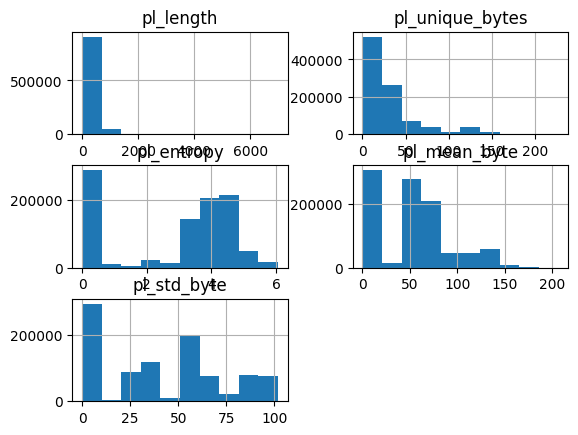

In [48]:
df[payload_feats].hist();

Some of the payload features are right-skewed so we'll apply log transform, adding a 1 to avoid -inf outputs.

In [49]:
df.loc[:, ["pl_length", "pl_unique_bytes"]] = df[["pl_length", "pl_unique_bytes"]].apply(lambda x: np.log(x+1))

C:\Users\lucch\AppData\Local\Temp\ipykernel_23952\4105607836.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         2.56494936 4.00733319 ... 6.06145692 5.80513497 3.17805383]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, ["pl_length", "pl_unique_bytes"]] = df[["pl_length", "pl_unique_bytes"]].apply(lambda x: np.log(x+1))
C:\Users\lucch\AppData\Local\Temp\ipykernel_23952\4105607836.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         2.39789527 3.4657359  ... 4.18965474 4.06044301 2.83321334]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, ["pl_length", "pl_unique_bytes"]] = df[["pl_length", "pl_unique_bytes"]].apply(lambda x: np.log(x+1))


#### Time features

Next we extract the features from the timestamp field, like we did in the previous notebook. I tried using all of them but some of them felt redundant or useless, so we'll instead focus on useful flags (is_weekend, is_night and work_hour) that may be useful to identify human attackers routines. Note that the timezone being UCT affects the flags, making them quite noisy.

 I still add the our, minute and month to have a minimum of specific temporal knowledge.

In [50]:
def extract_timestamp_features(ts):
    features = {
        'hour': ts.hour,
        'minute': ts.minute,
        # 'second': ts.second,
        # 'microsecond': ts.microsecond,
        'day_of_week': ts.dayofweek,
        'is_night': int(ts.hour < 6 or ts.hour >= 22),
        'is_work_hour': int(9 <= ts.hour < 17),
        # 'day': ts.day,
        'month': ts.month,
        # 'year': ts.year,
    'is_weekend': int(ts.dayofweek >= 5)}
    return features

In [52]:
df

,src_port,dst_port,timestamp,src_as,src_countryCode,src_ip,src_proxy,dst_ip,dst_proxy,src_lat,...,protocol_category_messaging,protocol_category_other,protocol_category_remote_access,protocol_category_vpn,protocol_category_web,pl_length,pl_unique_bytes,pl_entropy,pl_mean_byte,pl_std_byte
0,5008,21,1993-05-16 11:01:12.818000+00:00,135377,31541,152.32.252.211,1,149.248.11.187,0,22.3193,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,53478,22,1993-05-16 11:01:19.699000+00:00,207566,44361,92.255.57.132,1,139.84.241.125,0,55.7558,...,0,0,1,0,0,2.564949,2.397895,3.251629,56.416667,27.941780
2,64357,3389,1993-05-16 11:03:07.439000+00:00,54155,154068,198.71.78.105,0,149.248.11.187,0,33.7555,...,0,0,1,0,0,4.007333,3.465736,4.434809,57.314815,54.359511
3,53732,23,1993-05-16 11:03:08.131000+00:00,4134,105169,113.24.188.54,0,139.84.241.125,0,37.8389,...,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
4,37146,23,1993-05-16 11:03:10.260000+00:00,4134,105169,1.205.153.253,0,139.84.241.125,0,27.6867,...,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965085,39495,443,1993-08-14 10:58:33.294000+00:00,6939,154068,65.49.1.203,0,70.34.204.162,0,37.7232,...,0,0,0,0,1,5.176150,3.806662,4.150157,97.653409,96.696569
965086,33795,25,1993-08-14 10:58:53.445000+00:00,6939,154068,64.62.156.200,0,70.34.204.162,0,44.9764,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
965087,36880,80,1993-08-14 10:59:13.060000+00:00,36680,52624,154.81.156.54,0,104.207.157.17,0,50.8933,...,0,0,0,0,1,6.061457,4.189655,5.527596,77.815421,32.200758
965088,56274,3389,1993-08-14 10:59:57.188000+00:00,14061,154068,159.203.177.92,0,104.207.157.17,0,40.7964,...,0,0,1,0,0,5.805135,4.060443,5.266487,82.555891,31.829309


In [51]:
from timezonefinder import TimezoneFinder

ModuleNotFoundError: No module named 'timezonefinder'

In [ ]:
def extract_timestamp_features_specific_timezone(df, timestamp_col='timestamp', lat_col='lat', lon_col='lon'):
    feature_list = []
    tf = TimezoneFinder()
    
    for _, row in tqdm(df.iterrows()):
        ts_utc = row[timestamp_col]
        lat = row[lat_col]
        lon = row[lon_col]
        
        tz_str = tf.timezone_at(lng=lon, lat=lat)
        
        if tz_str is None:
            tz_str = 'UTC'
        
        local_ts = ts_utc.tz_convert(tz_str) if ts_utc.tzinfo else ts_utc.tz_localize('UTC').tz_convert(tz_str)
        
        features = {
            'hour': local_ts.hour,
            'minute': local_ts.minute,
            'day_of_week': local_ts.dayofweek,
            'is_night': int(local_ts.hour < 6 or local_ts.hour >= 22),
            'is_work_hour': int(9 <= local_ts.hour < 17),
            'month': local_ts.month,
            'is_weekend': int(local_ts.dayofweek >= 5)
        }
        
        feature_list.append(features)
    
    features_df = pd.DataFrame(feature_list)
    return features_df

In [ ]:
time_features = extract_timestamp_features_specific_timezone(df, lat_col="src_lat", lon_col="src_lon")
df = pd.concat([df, time_features], axis=1)

965090it [05:02, 3190.39it/s]


In [ ]:
# time_features = df['timestamp'].apply(extract_timestamp_features).apply(pd.Series)
# df = pd.concat([df, time_features], axis=1)

Next, sliding windows. This was our ace, analyzing the data with windows is helpful to identify burst of attacks, or periodicity. To do so we'll segment the dataset into windows of 5 minutes (quite granular) and group the observation by the IP of the source, computing useful information.

In [ ]:
def sliding_window_features(df, window_size='5min', step_size='1min'):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()
    
    start = df.index.min()
    end = df.index.max()
    window_starts = pd.date_range(start, end, freq=step_size)
    
    country_cols = [col for col in df.columns if col.startswith('dst_countryCode_')]
    proto_cols = [col for col in df.columns if col.startswith('protocol_category_')]
    
    features = []
    for window_start in tqdm(window_starts):
        window_end = window_start + pd.Timedelta(window_size)
        window_df = df[window_start:window_end]
        if window_df.empty:
            continue
        
        grouped = window_df.groupby('src_ip')
        for src_ip, group in grouped:
            interarrival = group.index.to_series().diff().dt.total_seconds()  # interarrival time, very important, measures how quick the same IP made attacks          

            feature_row = {
                'window_start': window_start,
                'src_ip': src_ip,
                'connection_count': len(group), # degree of activity
                
                'unique_dst_ips': group['dst_ip'].nunique(), # target diversity
                'unique_dst_ports': group['dst_port'].nunique(),
                
                'avg_pl_length': group['pl_length'].mean(), # payload statistics averaged
                'std_pl_entropy': group['pl_entropy'].std(),
                'mean_pl_mean_byte': group['pl_mean_byte'].mean(),
                'std_pl_std_byte': group['pl_std_byte'].std(),
                
                'std_interarrival_time': interarrival.fillna(0).std(),
                
                'hour_mode': group['hour'].mode().iloc[0] if not group['hour'].mode().empty else np.nan, # fraction done during flagged time ranges
                'fraction_at_night': group['is_night'].mean(),
                'fraction_on_weekend': group['is_weekend'].mean(),
                'fraction_during_work_hour': group['is_work_hour'].mean(),
                
                'unique_dst_countries': group[country_cols].sum().gt(0).sum(),
                'unique_protocol_categories': group[proto_cols].sum().gt(0).sum(), # diversity of operations
            }
            features.append(feature_row)

    return pd.DataFrame(features)


Since we extracted features for each window, not row, we need a function to assign rows to specific windows.

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

def assign_window_features(df, window_features, window_size='5min'):
    window_size = pd.Timedelta(window_size)
    window_features = window_features.copy()
    window_features['window_end'] = window_features['window_start'] + window_size

    df_with_features = pd.merge_asof(
        df.sort_values('timestamp'),
        window_features.sort_values('window_start'),
        by='src_ip',
        left_on='timestamp',
        right_on='window_start',
        direction='backward',
        tolerance=window_size
    )
    return df_with_features


We will apply this to the shorter dataset, removing the duplicated rows, since it takes a lot.

In [ ]:
df_no_dupes = df.drop_duplicates()

In [ ]:
feats = sliding_window_features(df_no_dupes, window_size="5min", step_size="2min")

feats['std_interarrival_time'] = feats['std_interarrival_time'].fillna(0)
feats['std_pl_entropy'] = feats['std_pl_entropy'].fillna(0)
feats['std_pl_std_byte'] = feats['std_pl_std_byte'].fillna(0)

100%|██████████| 64800/64800 [30:09<00:00, 35.82it/s]  


In [ ]:
df_no_dupes = assign_window_features(df_no_dupes, feats, '5min')
df_no_dupes.drop(columns=["window_end", "window_start"], inplace=True)

In [ ]:
# df.to_pickle("tmp/omnipot_extracted.pkl")
# df_no_dupes.to_pickle("tmp/omnipot_extracted_short.pkl")

In [ ]:
df = pd.read_pickle("tmp/omnipot_extracted.pkl")
df_no_dupes = pd.read_pickle("tmp/omnipot_extracted_short.pkl")

In [ ]:
df_short = df_no_dupes.drop(columns=["timestamp", "src_lat", "src_lon", "src_ip", "dst_ip", "dst_lat", "dst_lon"])
df_short.drop(inplace=True, columns=df_short.columns[df_short.nunique() == 1].tolist())
df_short.shape

(677953, 73)

These are the final columns, however later we will remove the country codes.

In [ ]:
df_short.columns

Index(['src_port', 'dst_port', 'src_as', 'src_countryCode', 'src_proxy',
       'dst_proxy', 'src_lat_sin', 'src_lat_cos', 'src_lon_sin', 'src_lon_cos',
       'dst_lat_sin', 'dst_lat_cos', 'dst_lon_sin', 'dst_lon_cos',
       'dst_countryCode_CA', 'dst_countryCode_CL', 'dst_countryCode_DE',
       'dst_countryCode_ES', 'dst_countryCode_FR', 'dst_countryCode_GB',
       'dst_countryCode_IL', 'dst_countryCode_IN', 'dst_countryCode_JP',
       'dst_countryCode_KR', 'dst_countryCode_MX', 'dst_countryCode_NL',
       'dst_countryCode_PL', 'dst_countryCode_SE', 'dst_countryCode_SG',
       'dst_countryCode_US', 'dst_countryCode_ZA', 'src_oct1', 'src_oct2',
       'src_oct3', 'src_oct4', 'dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4',
       'protocol_category_email', 'protocol_category_file_transfer',
       'protocol_category_iot', 'protocol_category_messaging',
       'protocol_category_other', 'protocol_category_remote_access',
       'protocol_category_vpn', 'protocol_category_web', 'pl

Since we can't use Robust Scaling before PCA, we'll handle the outliers of the real-valued features with the Interquantile range.

In [ ]:
to_handle = df_short.select_dtypes(float).columns.tolist()

In [ ]:
Q1 = df_short[to_handle].quantile(0.25)
Q3 = df_short[to_handle].quantile(0.75)

IQR = Q3 - Q1

low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR

In [ ]:
df_short[to_handle] = df_short[to_handle].clip(lower=low_lim, upper=up_lim, axis=1) #cap the features to the whiskers of the boxplot

#### Data Exploration and visualization

Let's visualize (a much smaller version of) the dataset using an interactive globe with folium. 

We'll plot each source only once, and show every possible destination. This skips a lot of the rows and the interactions, but it's just a way to visualize the data and understand it.

In [224]:
sampled = df.sample(1000)

to_plot_src = sampled[["src_lat", "src_lon", "src_ip", "dst_lat", "dst_lon", "dst_ip"]].drop_duplicates(["src_lat", "src_lon"])
to_plot_dst = df[["dst_lat", "dst_lon", "dst_ip"]].drop_duplicates(["dst_lat", "dst_lon"])

to_plot_dst.shape

(50, 3)

In [225]:
import folium

m = folium.Map(location=[20, 0], zoom_start=2)

n_to_show = 250

for row in to_plot_src[["src_lat", "src_lon", "src_ip", "dst_lat", "dst_lon", "dst_ip"]].iloc[:n_to_show].itertuples(index=False):
    lat, lon, ip, dlat, dlon, dip = row
    popup = f"Source IP: {ip}\n\n Lat: {lat}\n Lon: {lon}"

    folium.CircleMarker(
    location=(lat, lon),
    radius=5, 
    color='red',
    fill=True,
    fill_color='purple',
    fill_opacity=0.7,
    popup=popup
).add_to(m)
    
    folium.PolyLine(
    locations=[(lat, lon), (dlat, dlon)],
    color='brown',
    weight=3,
    opacity=0.3
).add_to(m)

    
for lat, lon, ip in list(zip(to_plot_dst["dst_lat"], to_plot_dst["dst_lon"], to_plot_dst["dst_ip"])):
    popup = f"Destination IP: {ip}\n\n Lat: {lat}\n Lon: {lon}"
    folium.CircleMarker(
    location=(lat, lon),
    radius=7, 
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7,
    popup=popup
).add_to(m)

m

The attacks span all continents, with a focus on America and Europe and the eastern Asia.

There were many duplicates also within the time column, possibly attacks that happened at the same time to different devices or from different attacking IPs. We assumed that the fully duplicated rows instead were redundant or mistakenly put in the data.

In [226]:
df.duplicated("timestamp").sum()

289263

In [227]:
df["timestamp"].value_counts()[:5]

timestamp
1993-07-05 08:43:03.032000+00:00    41964
1993-07-05 08:43:02.833000+00:00    12186
1993-07-05 08:43:00.206000+00:00     8421
1993-07-05 08:43:06.989000+00:00     5785
1993-06-06 16:16:12.317000+00:00     4415
Name: count, dtype: int64

Period covered:
1993-05-16 11:01:12.818000+00:00 - 1993-08-14 11:00:53.960000+00:00


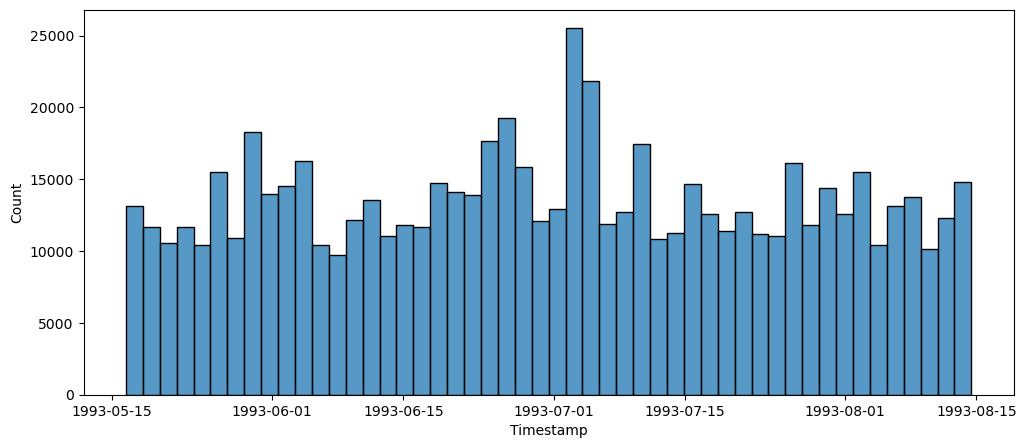

In [228]:
plt.figure(figsize=(12, 5))
print(f"Period covered:\n{str(df_no_dupes['timestamp'].min())} - {str(df_no_dupes['timestamp'].max())}")
sns.histplot(df_no_dupes, x="timestamp", bins=50)
plt.xlabel("Timestamp");

The attacks are from over 30 years ago, and their range is around 3 months.

We plot the 100 most active IP addresses over time, using sliding windows.

In [229]:
ips_to_plot = df_no_dupes["src_ip"].value_counts().iloc[:100].index.tolist()

In [230]:
df_tmp = df_no_dupes[df_no_dupes.src_ip.isin(ips_to_plot)].set_index('timestamp')

In [231]:
import plotly.express as px

In [232]:
df_tmp["src_ip"].value_counts().iloc[:5]

src_ip
92.255.57.58      4322
154.81.156.54     1970
185.196.220.81    1420
92.255.57.132     1334
154.81.156.10     1193
Name: count, dtype: int64

In [233]:
time_window = "5min"

grouped = df_tmp.groupby([pd.Grouper(freq=time_window), 'src_ip']).size().reset_index(name='count')
most_active_ips = grouped.loc[grouped.groupby('timestamp')['count'].idxmax()]


fig = px.line(most_active_ips, x='timestamp', y='count', color='src_ip',
              title='Most Active IPs per Time Window',
              labels={'count': 'Count of Attacks', 'timestamp': 'Time'},
              markers=True)

fig.show()

Most of them are quite consistent, but relatively low for each 5 minute window, IP 167.172.6.243 made a burst of attacks in july.

In [234]:
corr = df_short.corr()

We look at the Pearson correlation between the fields.

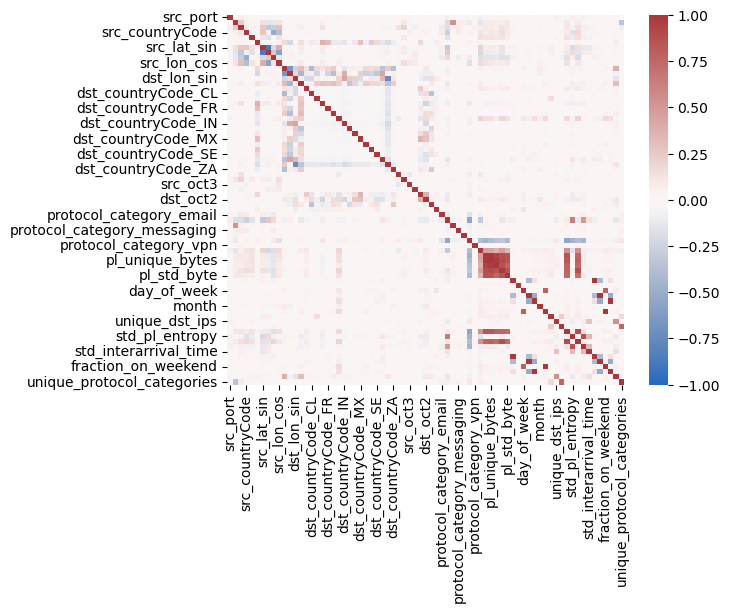

In [235]:
sns.heatmap(corr, annot=False, cmap="vlag", vmin=-1, vmax=1);

While in prediction tasks we like the features to be uncorrelated, they would bring a different source of knowledge, in clustering it's different as it's harder to cluster with uncorrelated information. So we expect the clustering to be harder, the matrix is quite blank.

We define a function to extract the number of components need for PCA to get n% of variance of the original data.

In [236]:
def pca_variance_threshold(X, t=0.9, plot=True):
    pca = PCA().fit(X)
    
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance, marker='o')
        plt.axhline(t, c="r")
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.show()
    
    count=1
    for var in cumulative_variance:
        if var<t:
            count+=1
            continue
        return count

Very importantly, we scale the data using standardization to get zero-mean and unit-variance. I tried different scaling methods and they yielded extremely different results.

In [237]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [238]:
scaler = StandardScaler().fit(df_short)
df_short_scaled = pd.DataFrame(scaler.transform(df_short), columns=scaler.get_feature_names_out())

df_short_scaled.mean(axis=0),df_short_scaled.var(axis=0).max()

(src_port                     -1.110117e-16
 dst_port                     -2.351871e-17
 src_as                        3.031021e-17
 src_countryCode              -3.253212e-17
 src_proxy                     2.542620e-17
                                   ...     
 fraction_at_night             1.432084e-16
 fraction_on_weekend          -4.292898e-17
 fraction_during_work_hour     1.408607e-16
 unique_dst_countries         -7.043036e-17
 unique_protocol_categories   -1.327277e-16
 Length: 73, dtype: float64,
 1.0000014750306823)

I originally kept the countries, but after applying a type of sequential feature selection to maximize a clustering score, it would often end after the first feature, a country code. And when plotted, the cluster was well-isolated. So basically the clustering was isolating attacks on different countries. While this is a meaningful analysis, we wanted to cluster the attacks based on what they were not the country they targeted, so for the rest of the workflow we left just the latitude and longitude of source and destination as geographical information. 

In [239]:
codes = [x for x in df_short_scaled.columns if x.startswith("dst_countryC")]

In [240]:
df_short_scaled.drop(columns=codes, inplace=True)

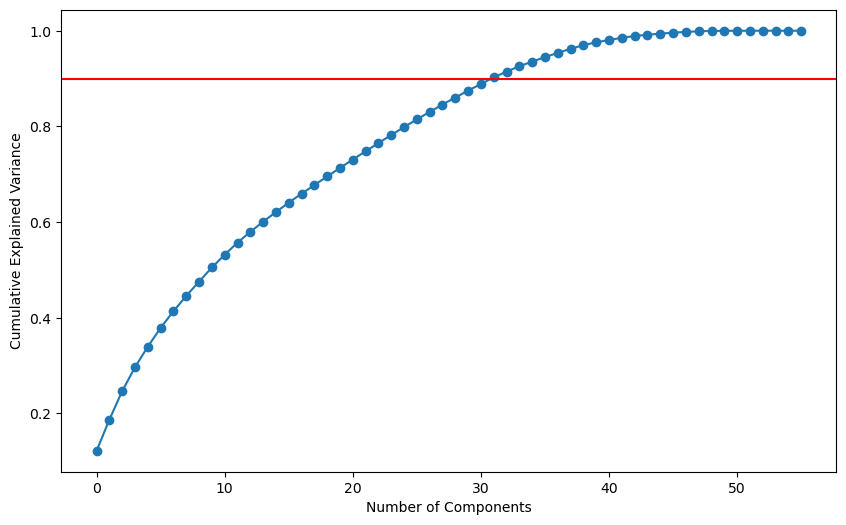

32

In [241]:
n_comps = pca_variance_threshold(df_short_scaled, t=0.9, plot=True)
n_comps

# Clustering

We perform an initial PCA to get features that are more dense in information than what we have now, also to reduce the dimensionality, since we also have a lot of observations.

In [242]:
pca = PCA(n_components=n_comps).fit(df_short_scaled)
pca_comps = pca.transform(df_short_scaled)
df_short_scaled_red = pd.DataFrame(pca_comps, columns=pca.get_feature_names_out())
df_short_scaled_red.shape

(677953, 32)

We can check how much each feature is present in the PCA components from the loadings.

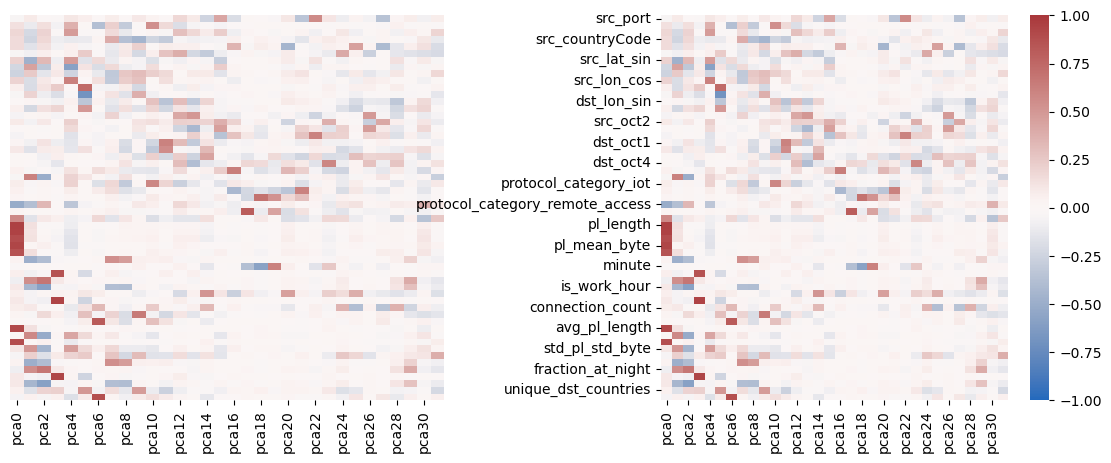

In [243]:
correlations = pd.DataFrame(
    np.corrcoef(df_short_scaled.T, pca_comps.T)[:len(df_short_scaled.columns), len(df_short_scaled.columns):],
    columns=df_short_scaled_red.columns,
    index=df_short_scaled.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.5)

high_corrs = correlations[(correlations.abs() > 0.3).any(axis=1)]
sns.heatmap(high_corrs, vmin=-1, vmax=1, cmap="vlag", ax=ax2)
sns.heatmap(correlations, vmin=-1, vmax=1, cmap="vlag", ax=ax1, cbar=False)
ax1.yaxis.set_visible(False)

In [244]:
for i, comp in enumerate(pca.components_, 1):
    print(f"PC{i} top features:")
    idxs = comp.argsort()[::-1][:5]
    for ind in idxs:
        print(f"{df_short_scaled.columns[ind]}: {comp[ind]}")
    print()

PC1 top features:
pl_length: 0.3615869687429618
pl_unique_bytes: 0.36130715433530414
pl_mean_byte: 0.3539644053274006
avg_pl_length: 0.34704806102957303
pl_entropy: 0.34043113706397937

PC2 top features:
protocol_category_file_transfer: 0.3221932819683774
std_pl_entropy: 0.3016208535322522
is_night: 0.2877956181886202
fraction_at_night: 0.28755625179815814
std_pl_std_byte: 0.26259758321061255

PC3 top features:
fraction_at_night: 0.3688320259736929
is_night: 0.36870591077916215
protocol_category_remote_access: 0.18579498786877102
src_lat_sin: 0.18161615775287404
unique_dst_countries: 0.11098034358222689

PC4 top features:
is_weekend: 0.5561809958811905
fraction_on_weekend: 0.5561179724954808
day_of_week: 0.514214357624784
dst_lat_sin: 0.14396917030212925
unique_dst_countries: 0.12796300308590597

PC5 top features:
src_lon_cos: 0.40057680761390246
src_as: 0.3104991663895106
src_lat_sin: 0.307978262182438
std_pl_std_byte: 0.29954353982443693
std_pl_entropy: 0.27290951903234173

PC6 top f

It seems that the first principal components focuses on the payload, which is quite promising. The second and thirs on the night hours and the file transfer protocol, and more payload. The fourth instead is interested in the day of the week... this is good the components seem to each have a goal, and there aren't features that overshadow the others.

We create a function to run a clustering method, calculate the Calinski-Harabasz Score (CH "$\in [0, \infty]$), very fast to compute even on 600 thousand rows, and the silhouette score, very slow, thus done on subsets of data. The most expensive algorithms will also be trained on the shorter dataset.

In [245]:
def quickrun_clustering(X, algo, sample_indices = None, short_train=False, return_scores = False,**algo_kwargs):
    if sample_indices is None:
        sample_indices = np.random.choice(len(df_short_scaled_red), size=30000, replace=False)
        
    if short_train:
        clusters = pd.Series(algo(**algo_kwargs).fit_predict(X.loc[sample_indices]), index=X.loc[sample_indices].index)
        sil = sil_(X.loc[sample_indices], clusters)
        ch = calinski_(X.loc[sample_indices], clusters)
    else:
        clusters = pd.Series(algo(**algo_kwargs).fit_predict(X), index=X.index)
        sil = sil_(X.loc[sample_indices], clusters.iloc[sample_indices])
        ch = calinski_(X, clusters)
        
    print("Approximated Silhouette Score: ", sil)
    print("Calisnki Harabasz Score: ", ch)
    clusters.value_counts()

    if return_scores:
        return clusters, {"silhouette": sil, "CH": ch}    

    return clusters

In [246]:
sample_indices = np.random.choice(len(df_short_scaled_red), size=50000, replace=False)

In [247]:
clusters_km = quickrun_clustering(df_short_scaled_red, KMeans, sample_indices, n_clusters=2)

Approximated Silhouette Score:  0.10809205136402167
Calisnki Harabasz Score:  77952.86077518483


K-Means obtains a  Silhouette score of around 0.1 (in certain runs i obtained 0.35)... not very good but it's closer to 1 than to -1, so it's something.

In [248]:
clusters_km.value_counts()

0    457491
1    220462
Name: count, dtype: int64

In [249]:
clusters_km_full = quickrun_clustering(df_short_scaled, KMeans, sample_indices, n_clusters=2)

Approximated Silhouette Score:  0.09652094704472193
Calisnki Harabasz Score:  69679.43539271978


The performance using all features instead of the reduced components is worse.

In [250]:
for i in range(2, 10):
    quickrun_clustering(df_short_scaled_red, KMeans, sample_indices, n_clusters=i)

Approximated Silhouette Score:  0.10809205136402167
Calisnki Harabasz Score:  77952.86077518483
Approximated Silhouette Score:  0.09210242758270862
Calisnki Harabasz Score:  56431.5916855526
Approximated Silhouette Score:  0.08454452193385605
Calisnki Harabasz Score:  47407.025371146796
Approximated Silhouette Score:  0.08109865067157954
Calisnki Harabasz Score:  40009.97277102733
Approximated Silhouette Score:  0.06524347250938535
Calisnki Harabasz Score:  35091.70919860151
Approximated Silhouette Score:  0.06253559679895278
Calisnki Harabasz Score:  31278.361587202042
Approximated Silhouette Score:  0.06950042458383052
Calisnki Harabasz Score:  31128.930362306517
Approximated Silhouette Score:  0.0752901052321889
Calisnki Harabasz Score:  29966.43332957196


2 clusters lead to the best scores ... the rest are even worse.

In [251]:
clusters_gmm = quickrun_clustering(df_short_scaled_red, GaussianMixture, sample_indices, short_train=False, n_components=2)

Approximated Silhouette Score:  0.09572457290076189
Calisnki Harabasz Score:  72347.581114464


GMM is competitive although slighty less good.

In [252]:
clusters_db = quickrun_clustering(df_short_scaled_red, DBSCAN, sample_indices, short_train=True)

Approximated Silhouette Score:  -0.21729633490172062
Calisnki Harabasz Score:  49.016046002575976


DBSCAN it's bad, there is likely something we need to do different with DBSCAN, I will study in the future as this algorithm is new for me.

In [253]:
simple_tsne_comps = TSNE(n_components=2, perplexity=100).fit_transform(df_short_scaled_red.loc[sample_indices])

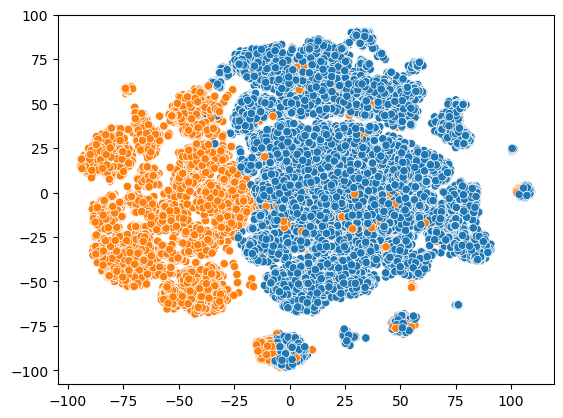

In [254]:
sns.scatterplot(x=simple_tsne_comps[:, 0], y=simple_tsne_comps[:, 1], hue=clusters_km.loc[sample_indices]), plt.legend([], frameon=False);

Well the t-SNE component plot is actually promising. There is one big cloud of points, with smaller clusters, so we can't say that the division was good, but at least the found K-Means labels are on different sides.

In [255]:
from collections import Counter

In [256]:
def summarize_numeric_clusters(df, feature_cols, labels, top_n=5):
    labels = np.asarray(labels)
    n_clusters = len(np.unique(labels))

    counts = Counter(labels)
    print("Cluster sizes:")
    for clust, cnt in sorted(counts.items()):
        print(f"  Cluster {clust}: {cnt} samples")
    print()

    global_mean = df[feature_cols].mean()

    for k in sorted(counts.keys()):
        cluster_mean = df.loc[labels == k, feature_cols].mean()
        diffs = (cluster_mean - global_mean).abs().sort_values(ascending=False)
        top_features = diffs.index[:top_n].tolist()
        print(f"Cluster {k} top distinguishing features:")
        for feat in top_features:
            mean_val = cluster_mean[feat]
            diff = cluster_mean[feat] - global_mean[feat]
            print(f"    {feat}: cluster mean = {mean_val:.3f} ({'+' if diff>=0 else ''}{diff:.3f} vs global)")
        print()

In [257]:
summarize_numeric_clusters(df_short_scaled_red, df_short_scaled_red.columns, clusters_km)

Cluster sizes:
  Cluster 0: 457491 samples
  Cluster 1: 220462 samples

Cluster 0 top distinguishing features:
    pca0: cluster mean = 1.547 (+1.547 vs global)
    pca4: cluster mean = -0.168 (-0.168 vs global)
    pca1: cluster mean = 0.165 (+0.165 vs global)
    pca30: cluster mean = 0.099 (+0.099 vs global)
    pca3: cluster mean = -0.086 (-0.086 vs global)

Cluster 1 top distinguishing features:
    pca0: cluster mean = -3.211 (-3.211 vs global)
    pca4: cluster mean = 0.348 (+0.348 vs global)
    pca1: cluster mean = -0.342 (-0.342 vs global)
    pca30: cluster mean = -0.205 (-0.205 vs global)
    pca3: cluster mean = 0.178 (+0.178 vs global)



The features with the larges difference between the two classes are PC{0, 1, 3, 4, 6}, let's check what they are about.

In [258]:
for i, comp in enumerate(pca.components_):
    if i in [0, 1, 4, 3 ,6]:
        print(f"PC{i} top features:")
        idxs = comp.argsort()[::-1][:5]
        for ind in idxs:
            print(f"{df_short_scaled.columns[ind]}: {comp[ind]}")
        print()

PC0 top features:
pl_length: 0.3615869687429618
pl_unique_bytes: 0.36130715433530414
pl_mean_byte: 0.3539644053274006
avg_pl_length: 0.34704806102957303
pl_entropy: 0.34043113706397937

PC1 top features:
protocol_category_file_transfer: 0.3221932819683774
std_pl_entropy: 0.3016208535322522
is_night: 0.2877956181886202
fraction_at_night: 0.28755625179815814
std_pl_std_byte: 0.26259758321061255

PC3 top features:
is_weekend: 0.5561809958811905
fraction_on_weekend: 0.5561179724954808
day_of_week: 0.514214357624784
dst_lat_sin: 0.14396917030212925
unique_dst_countries: 0.12796300308590597

PC4 top features:
src_lon_cos: 0.40057680761390246
src_as: 0.3104991663895106
src_lat_sin: 0.307978262182438
std_pl_std_byte: 0.29954353982443693
std_pl_entropy: 0.27290951903234173

PC6 top features:
unique_protocol_categories: 0.6300624513641685
unique_dst_ports: 0.5856450971529609
connection_count: 0.23660355403841754
protocol_category_web: 0.12762247389404774
src_lat_sin: 0.12050578534482127



Indeed they are what we commented earlier already, and since PC2 and PC3 were very similar, we are happy to find only one here. I believe this is a good result as each component has a different focus, meaning that the clusters are actually different in many ways, and not a couple of features.

Possible interpretations:
* Cluster 0:
        Strongly positive PC0, slightly positive  PC1, negative  PC4, PC3, PC6.
        A positive PC0 implies larger payloads, higher entropy, and more diverse operations, humans are not based on scripts and may also explore the environment before acting. They don't have templates.
        Positive PC1 which is about night activity and file transfer protocols.
        Negative PC3, less associated with weekends, consistent behavior through the week, humans tend to focus on rest and hobbies during the weekend.
        Negative PC6, fewer unique protocol types and ports. Humans don't have the time nor the possibility to manually target many different services.
        -> Likely Human Hackers

*  Cluster 1:
    Strongly negative PC0 and slightly positive  PC4, PC3, and PC6.
        Since PC0 is mainly about payload size and entropy a large negative PC0 indicates that traffic in Cluster 0 has shorter and less diverse payloads. Lower entropy suggests less randomness, typical for automated bots which may send repetitive payloads.
        The positive PC4 loading (location features like src_lon_cos, src_as, src_lat_sin) suggests some geographical or AS clustering, possibly coming from a set of networks.
        PC3 could mean more activity during weekends, although I would expect humans attackers to be more active during weekends instead, since during the week they may work, it's also true that humans may want to take weekends free as mentioned, so this could be associated to botnets.
        PC6 is small and positive there's variation in ports/protocols but not much.   
         -> Likely botnets.